In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [2]:
data = np.load('small_data_refined.npz')
X = data['X']
y = data['y'].reshape(-1, 1)

## Prepare data

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [4]:
from sklearn.utils.class_weight import compute_class_weight

cw = dict(enumerate(compute_class_weight('balanced', classes = np.unique(y_train.ravel()), y = y_train.ravel())))
# Add a bit more weight to 1 and since they always have the worst precision and recall
cw[1] += .2
cw[7] += .2

In [5]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train)

## Train model

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, AvgPool2D, Dropout

#LeNet-5 arch
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', padding='valid', input_shape = X_train.shape[1:]))
model.add(AvgPool2D(pool_size=(2,2)))
model.add(Conv2D(16, kernel_size=(5,5), activation='tanh', padding='valid'))
model.add(AvgPool2D(pool_size=(2,2)))
model.add(Dropout(0.23))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 16)          2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [7]:
history = model.fit(X_train, y_train, validation_split=.1, batch_size=32, epochs=15, shuffle=True, class_weight=cw)

Epoch 1/15
183/183 [==============================] - 1s 7ms/step - loss: 1.3362 - accuracy: 0.6254 - val_loss: 0.6167 - val_accuracy: 0.8182
Epoch 2/15
183/183 [==============================] - 1s 7ms/step - loss: 0.4995 - accuracy: 0.8659 - val_loss: 0.3796 - val_accuracy: 0.8968
Epoch 3/15
183/183 [==============================] - 1s 6ms/step - loss: 0.3568 - accuracy: 0.8984 - val_loss: 0.2933 - val_accuracy: 0.9076
Epoch 4/15
183/183 [==============================] - 1s 6ms/step - loss: 0.2910 - accuracy: 0.9192 - val_loss: 0.2871 - val_accuracy: 0.9260
Epoch 5/15
183/183 [==============================] - 1s 6ms/step - loss: 0.2445 - accuracy: 0.9306 - val_loss: 0.2331 - val_accuracy: 0.9307
Epoch 6/15
183/183 [==============================] - 1s 6ms/step - loss: 0.2140 - accuracy: 0.9322 - val_loss: 0.2194 - val_accuracy: 0.9399
Epoch 7/15
183/183 [==============================] - 1s 6ms/step - loss: 0.1951 - accuracy: 0.9400 - val_loss: 0.2046 - val_accuracy: 0.9445
Epoch 

In [8]:
model.save('models/lenet_10epochs_weighted_small_extended_refined.h5')

## Evaluate model

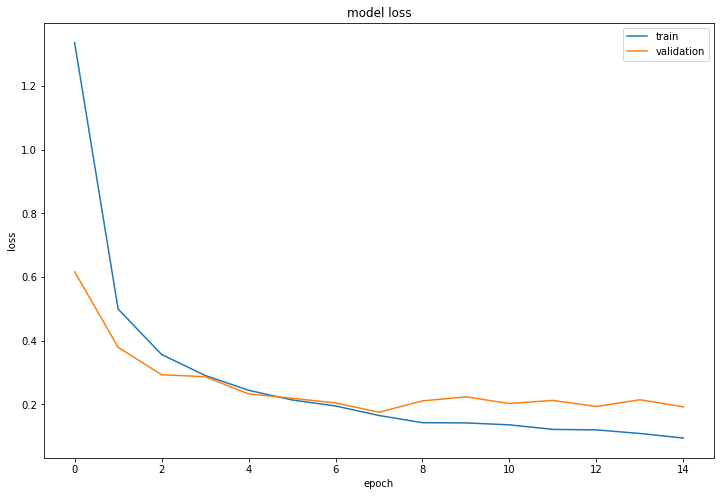

In [9]:
f, ax = plt.subplots(figsize=(12, 8))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')

plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

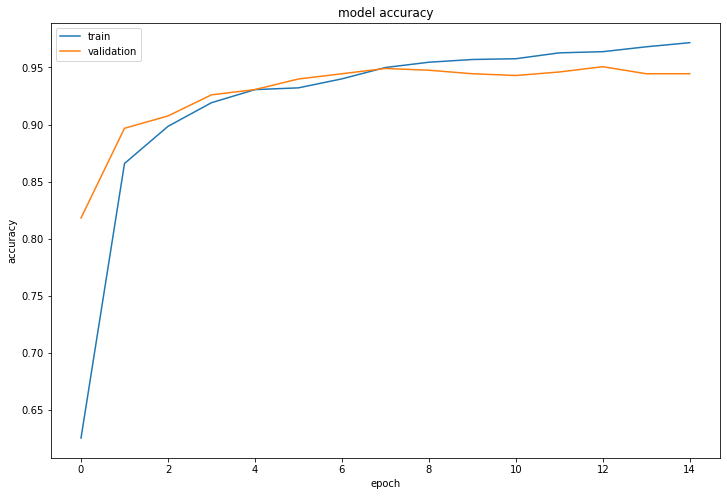

In [10]:
f, ax = plt.subplots(figsize=(12, 8))

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [11]:
preds = np.argmax(model.predict(X_test), axis=1)
preds = preds.reshape(preds.shape[0], 1)

Accuracy: 0.9568434032059187


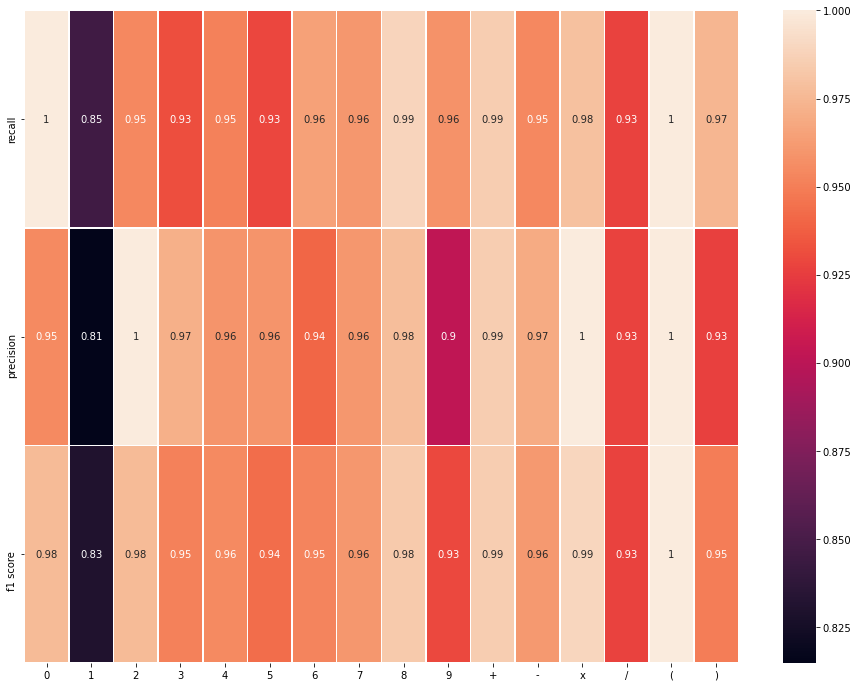

In [14]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import seaborn as sn

f, ax = plt.subplots(figsize=(16, 12))

print('Accuracy: {}'.format(accuracy_score(y_test, preds)))

recall = recall_score(y_test, preds, average=None)
precision = precision_score(y_test, preds, average=None)
f1 = f1_score(y_test, preds, average=None)
ax = sn.heatmap([recall, precision, f1], xticklabels=[str(i) for i in range(10)] + ['+', '-', 'x', '/', '(', ')'], yticklabels=['recall', 'precision', 'f1 score'], annot=True, linewidths=.5)

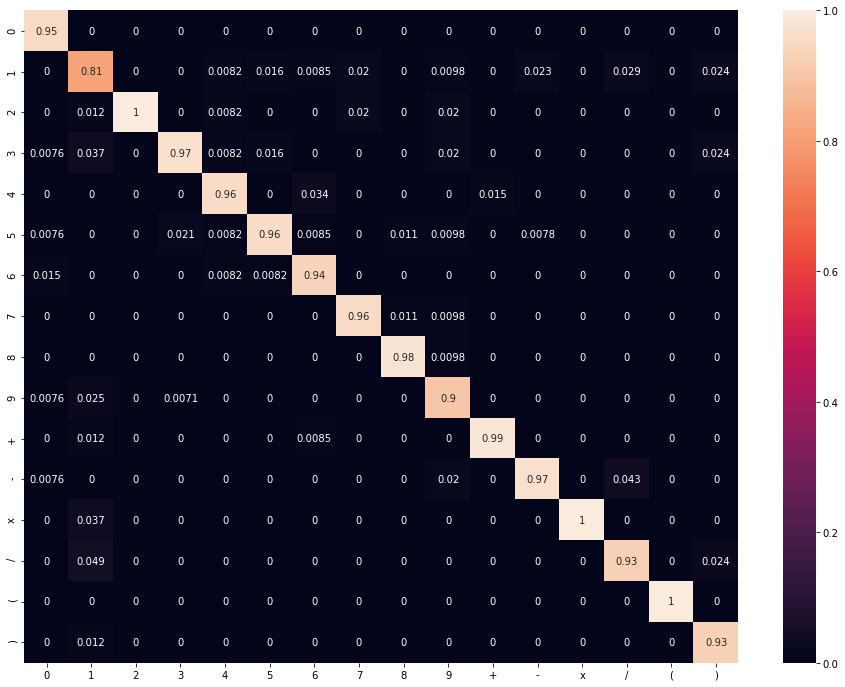

In [13]:
from sklearn.metrics import confusion_matrix

f, ax = plt.subplots(figsize=(16, 12))

cm = confusion_matrix(y_test, preds, normalize='pred')
ax = sn.heatmap(cm, annot=True, xticklabels=[str(i) for i in range(10)] + ['+', '-', 'x', '/', '(', ')'], yticklabels=[str(i) for i in range(10)] + ['+', '-', 'x', '/', '(', ')'])

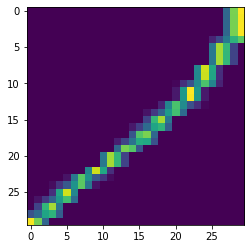

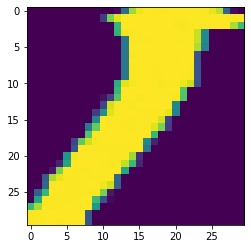

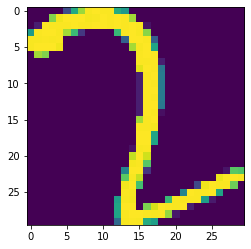

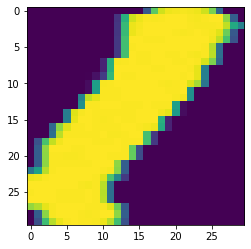

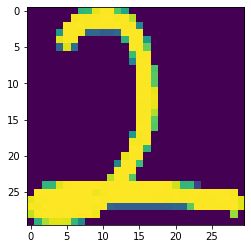

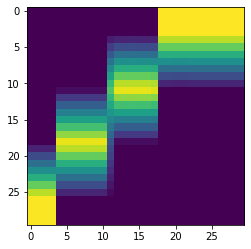

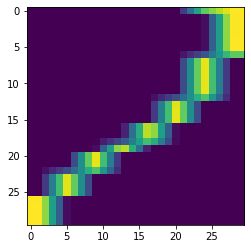

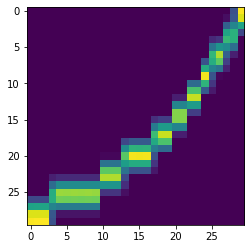

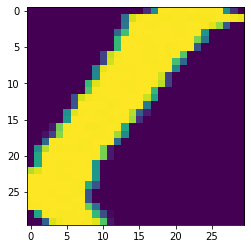

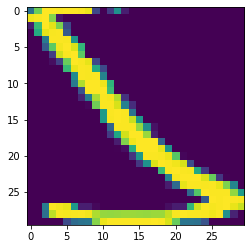

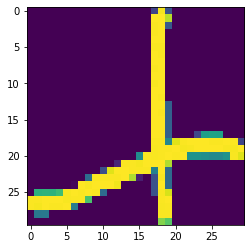

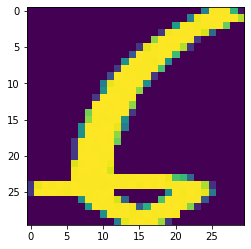

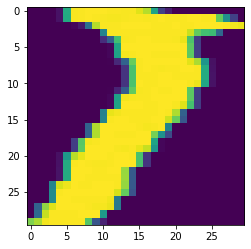

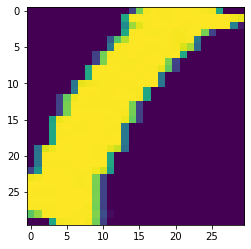

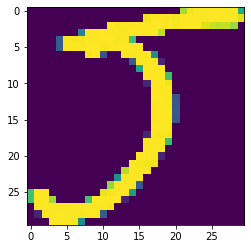

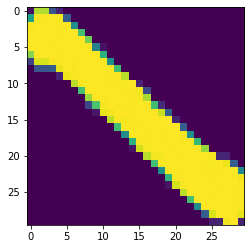

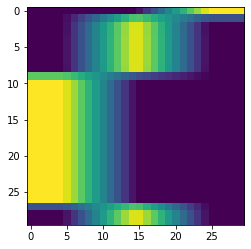

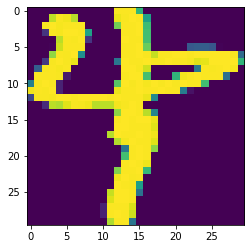

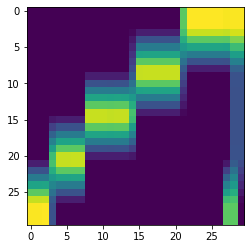

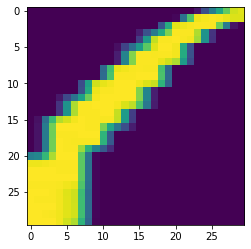

In [16]:
for i, pred in enumerate(preds):
    if y_test[i][0] != 1 and pred == 1:
        plt.imshow(X_test[i].reshape(30, 30))
        plt.show()